In [ ]:
!pip install fuzzywuzzy
!pip install parfit

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
  Created wheel for parfit: filename=parfit-0.220-py3-none-any.whl size=8660 sha256=614c763d2fc96b509325f881b57e73f13724c50b0bb4eed9e495692935f73a4c
  Stored in directory: /root/.cache/pip/wheels/9a/3b/19/64addee68f796a7e7108c2658a8765d600753bc728e7beb55e
  Created wheel for sklearn: filename=sklearn-0.0-py2.py3-none-any.whl size=1310 sha256=8e7ef1d492942c2ffed54a40cf0ef3187d8dbfde156b47a7974e16cba5d457ab
  Stored in directory: /root/.cache/pip/wheels/46/ef/c3/157e41f5ee1372d1be90b09f74f82b10e391eaacca8f22d33e
Successfully built parfit sklearn


In [ ]:
import os
import re
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns
import nltk
from nltk.corpus import stopwords
nltk.download('omw-1.4')
nltk.download('averaged_perceptron_tagger')
nltk.download('punkt')
nltk.download('wordnet')
nltk.download('stopwords')
from nltk.stem import WordNetLemmatizer
from nltk.corpus import wordnet
import json

from bs4 import BeautifulSoup
from nltk.stem import WordNetLemmatizer
from gensim.models import Word2Vec
from gensim.models import KeyedVectors
import string
from wordcloud import WordCloud, STOPWORDS
from fuzzywuzzy import fuzz


from ast import literal_eval
import tensorflow as tf
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from sklearn.model_selection import ParameterGrid
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.metrics import roc_auc_score
from sklearn.metrics import accuracy_score, log_loss
from scipy.spatial import distance

import parfit.parfit as pf
from sklearn.feature_extraction.text import TfidfVectorizer

import ast
from difflib import SequenceMatcher
from sklearn.utils import shuffle

from google.colab import drive
drive.mount('/content/drive')
path = "/content/drive/MyDrive/Copy-CDS-B3/Capstone/"

[nltk_data] Downloading package omw-1.4 to /root/nltk_data...
[nltk_data] Downloading package averaged_perceptron_tagger to
[nltk_data]     /root/nltk_data...
[nltk_data]   Unzipping taggers/averaged_perceptron_tagger.zip.
[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.
[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.
/usr/local/lib/python3.7/dist-packages/fuzzywuzzy/fuzz.py:11: UserWarning: Using slow pure-python SequenceMatcher. Install python-Levenshtein to remove this warning
  warnings.warn('Using slow pure-python SequenceMatcher. Install python-Levenshtein to remove this warning')


Mounted at /content/drive


In [ ]:
def clean_text(q):

    q = str(q).lower().strip()
    
    # Replace special characters with their string equivalents.
    q = q.replace('%', ' percent')
    q = q.replace('$', ' dollar ')
    q = q.replace('₹', ' rupee ')
    q = q.replace('€', ' euro ')
    q = q.replace('@', ' at ')
    
    # The pattern '[math]' appears many times in the whole dataset.
    #q = q.replace('[math]', '')
    
    # Replacing some numbers with string equivalents (not perfect, can be done better to account for more cases)
    q = q.replace(',000,000,000 ', 'b ')
    q = q.replace(',000,000 ', 'm ')
    q = q.replace(',000 ', 'k ')
    q = re.sub(r'([0-9]+)000000000', r'\1b', q)
    q = re.sub(r'([0-9]+)000000', r'\1m', q)
    q = re.sub(r'([0-9]+)000', r'\1k', q)
    
    # Decontracting words -  https://en.wikipedia.org/wiki/Wikipedia%3aList_of_English_contractions
    contractions = { "ain't": "am not", "aren't": "are not", "can't": "can not", "can't've": "can not have", "'cause": "because", "could've": "could have",
    "couldn't": "could not", "couldn't've": "could not have", "didn't": "did not", "doesn't": "does not", "don't": "do not", "hadn't": "had not",
    "hadn't've": "had not have", "hasn't": "has not", "haven't": "have not", "he'd": "he would", "he'd've": "he would have", "he'll": "he will",
    "he'll've": "he will have", "he's": "he is", "how'd": "how did", "how'd'y": "how do you", "how'll": "how will", "how's": "how is", "i'd": "i would",
    "i'd've": "i would have", "i'll": "i will", "i'll've": "i will have", "i'm": "i am", "i've": "i have", "isn't": "is not", "it'd": "it would",
    "it'd've": "it would have", "it'll": "it will", "it'll've": "it will have", "it's": "it is", "let's": "let us", "ma'am": "madam", "mayn't": "may not",
    "might've": "might have", "mightn't": "might not", "mightn't've": "might not have", "must've": "must have", "mustn't": "must not", "mustn't've": "must not have",
    "needn't": "need not", "needn't've": "need not have", "o'clock": "of the clock", "oughtn't": "ought not", "oughtn't've": "ought not have", "shan't": "shall not",
    "sha'n't": "shall not", "shan't've": "shall not have", "she'd": "she would", "she'd've": "she would have", "she'll": "she will", "she'll've": "she will have",
    "she's": "she is", "should've": "should have", "shouldn't": "should not", "shouldn't've": "should not have", "so've": "so have", "so's": "so as",
    "that'd": "that would", "that'd've": "that would have", "that's": "that is", "there'd": "there would", "there'd've": "there would have", "there's": "there is",
    "they'd": "they would", "they'd've": "they would have", "they'll": "they will", "they'll've": "they will have", "they're": "they are", "they've": "they have",
    "to've": "to have", "wasn't": "was not", "we'd": "we would", "we'd've": "we would have", "we'll": "we will", "we'll've": "we will have", "we're": "we are",
    "we've": "we have", "weren't": "were not", "what'll": "what will", "what'll've": "what will have", "what're": "what are", "what's": "what is", "what've": "what have",
    "when's": "when is", "when've": "when have", "where'd": "where did", "where's": "where is", "where've": "where have", "who'll": "who will", "who'll've": "who will have",
    "who's": "who is", "who've": "who have", "why's": "why is", "why've": "why have", "will've": "will have", "won't": "will not", "won't've": "will not have",
    "would've": "would have", "wouldn't": "would not", "wouldn't've": "would not have", "y'all": "you all", "y'all'd": "you all would", "y'all'd've": "you all would have",
    "y'all're": "you all are", "y'all've": "you all have", "you'd": "you would", "you'd've": "you would have", "you'll": "you will", "you'll've": "you will have",
    "you're": "you are", "you've": "you have" }

    qs_decontracted = []

    for word in q.split():
        if word in contractions:
            word = contractions[word]

        qs_decontracted.append(word)

    q = ' '.join(qs_decontracted)
    q = q.replace("'ve", " have")
    q = q.replace("n't", " not")
    q = q.replace("'re", " are")
    q = q.replace("'ll", " will")
    q = q.replace(" e g ", " eg ")
    q = q.replace(" b g ", " bg ")
    q = q.replace(" u s ", " american ")
    q = q.replace("e - mail", "email")
    q = q.replace("j k", "jk")
    
    # Removing HTML tags
    q = BeautifulSoup(q)
    q = q.get_text()
    
    # Remove punctuations
    pattern = re.compile('\W')
    q = re.sub(pattern, ' ', q).strip()      
    return(q)

def common_words(x):
    return len(set(x[0]) & set(x[1]))


def postags(sentence):
  #lowercase case and convert to string type
  x = str.lower(str(sentence))

  #add space between numbers and text
  x = re.sub('(\d+(\.\d+)?)', r' \1 ', x).strip()

  #remove non ascii characters
  x = x.encode('ascii',errors='ignore').decode('ascii')

  #clean text
  x = clean_text(x)
  
  # tokenize, remove punctuation & convert to lowercase
  tokens = nltk.word_tokenize(x)
  tokens = list(filter(lambda token: token not in string.punctuation, tokens))
    
  # find and return POS tag for each token
  return nltk.pos_tag(tokens)
  

def lemmatize(postags):
  
  lemmatizer = WordNetLemmatizer()

  lemmatized_tokens = []
  for word, tag in postags:
    #J Adjective, V - Verb, N - Noun, R - Adverb
    if tag[0] in ['A', 'V', 'N', 'R']:
      lemmatized_tokens.append(lemmatizer.lemmatize(word, str.lower(tag[0])))
    else:
      lemmatized_tokens.append(word)
  return lemmatized_tokens

def same_question(x):
  questions = ['what', 'when', 'who', 'which', 'why', 'how', 'where', 'whose','whom']
  same_type = False
  for question in questions:
    if (len(set(x[0]) & set([question])) > 0) & (len(set(x[1]) & set([question])) > 0):
        same_type = True
        break
  return int(same_type)

#returns number of specified tags in word list
def tag_count(pos_tags, tag):
  count = 0
  for word, ptag in pos_tags:
    if ptag[0] == str.upper(tag):
        count +=1
  return count

def percentshared(x):
  return x[2]/max(x[0],x[1])

def add_postags(getdf):
  #tags
  getdf['q1tags'] = getdf['question1'].apply(postags)
  getdf['q2tags'] = getdf['question2'].apply(postags)
  return getdf

def add_tokens(getdf):
  #tokens
  getdf['q1tokens'] = getdf['q1tags'].apply(lemmatize)
  getdf['q2tokens'] = getdf['q2tags'].apply(lemmatize)
  return getdf

def add_otherfeatures(getdf):
  #length of questions
  getdf['q1lens'] = getdf['q1tokens'].apply(lambda x: len(x))
  getdf['q2lens'] = getdf['q2tokens'].apply(lambda x: len(x))

  #number of common words
  getdf['commonwords'] = getdf[['q1tokens','q2tokens']].apply(lambda x: common_words(x), axis = 1)
  
  #same type of question
  getdf['samequestion'] = getdf[['q1tokens','q2tokens']].apply(lambda x: same_question(x), axis = 1)
  
  #% shared words
  getdf['%commonwords'] = getdf[['q1lens','q2lens','commonwords']].apply(lambda x: percentshared(x), axis = 1)
  
  #J Adjective, V - Verb, N - Noun, R - Adverb
  #tag count - Verbs
  getdf['q1_verb_count'] = getdf['q1tags'].apply(tag_count, args = ['V'])
  getdf['q2_verb_count'] = getdf['q2tags'].apply(tag_count, args = ['V'])

  #tag count - Nouns
  getdf['q1_noun_count'] = getdf['q1tags'].apply(tag_count, args = ['N'])
  getdf['q2_noun_count'] = getdf['q2tags'].apply(tag_count, args = ['N'])

  #tag count - Adjective
  getdf['q1_adj_count'] = getdf['q1tags'].apply(tag_count, args = ['J'])
  getdf['q2_adj_count'] = getdf['q2tags'].apply(tag_count, args = ['J'])

  #tag count - Adverb
  getdf['q1_adv_count'] = getdf['q1tags'].apply(tag_count, args = ['R'])
  getdf['q2_adv_count'] = getdf['q2tags'].apply(tag_count, args = ['R'])
  return getdf

def token_to_sentence(tokens):
  #tokens read as string from csv, convert back to list using ast package
  tokens = literal_eval(str(tokens))
  sentence = ''
  for token in tokens:
    sentence = sentence + " " + token
  return sentence

def add_fuzzy_features(getdf):  
  df1 = pd.DataFrame()
  df1['q1sent'] = getdf['q1tokens'].apply(token_to_sentence)
  df1['q2sent'] = getdf['q2tokens'].apply(token_to_sentence)
  # The token sort approach involves tokenizing the string in question, sorting the tokens alphabetically, and 
  # then joining them back into a string We then compare the transformed strings with a simple ratio().
  getdf["token_set_ratio"]       = df1.apply(lambda x: fuzz.token_set_ratio(x['q1sent'], x['q2sent']), axis=1)
  getdf["fuzz_ratio"]            = df1.apply(lambda x: fuzz.QRatio(x["q1sent"], x["q2sent"]), axis=1)
  getdf["fuzz_partial_ratio"]    = df1.apply(lambda x: fuzz.partial_ratio(x["q1sent"], x["q2sent"]), axis=1)  
  return getdf

                                          
#functions to add derived features
#cwc_min : Ratio of common_word_count to min lenghth of word count of Q1 and Q2
def cwc_min(x):
  return len(set(x[0]) & set(x[1]))/(min(len(set(x[0])),len(set(x[1])))+0.0001)

#cwc_max : Ratio of common_word_count to max lenghth of word count of Q1 and Q2
def cwc_max(x):
  return len(set(x[0]) & set(x[1]))/(max(len(set(x[0])),len(set(x[1])))+0.0001)

#ctc_min : Ratio of non stop words to min length of non stop count of Q1 and Q2
def ctc_min(x):
  #Get non-stopwords in questions
  q1_words = set([word for word in x[0] if word not in STOPWORDS])
  q2_words = set([word for word in x[1] if word not in STOPWORDS])

  return len(set(q1_words) & set(q2_words))/(min(len(q1_words),len(q2_words))+0.0001)

#ctc_max : Ratio of non stop words to min length of non stop count of Q1 and Q2
def ctc_max(x):
  #Get non-stopwords in questions
  q1_words = set([word for word in x[0] if word not in STOPWORDS])
  q2_words = set([word for word in x[1] if word not in STOPWORDS])

  return len(set(q1_words) & set(q2_words))/(max(len(q1_words),len(q2_words))+0.0001)

#abs_len_diff : Abs. length difference
def abs_len_diff(x):
  return abs(len(x[0]) - len(x[1]))

#mean_len : Average Token Length of both Questions
def mean_len(x):
  return (len(x[0]) + len(x[1]))/2

#consolidated function to add derived features

def seq_ratio(x):
  return SequenceMatcher(None, x[0], x[1]).ratio()


def add_derived_features(getdf):

  getdf['q1tokens'] = getdf['q1tokens'].apply(lambda x: literal_eval(str(x)))
  getdf['q2tokens'] = getdf['q2tokens'].apply(lambda x: literal_eval(str(x)))
  #cwc_min : Ratio of common_word_count to min lenghth of word count of Q1 and Q2
  getdf['cwc_min'] = getdf[['q1tokens','q2tokens']].apply(lambda x: cwc_min(x), axis = 1)
  #cwc_max : Ratio of common_word_count to max lenghth of word count of Q1 and Q2
  getdf['cwc_max'] = getdf[['q1tokens','q2tokens']].apply(lambda x: cwc_max(x), axis = 1)
  #ctc_min : Ratio of non stop words to min length of non stop count of Q1 and Q2
  getdf['ctc_min'] = getdf[['q1tokens','q2tokens']].apply(lambda x: ctc_min(x), axis = 1)
  #ctc_max : Ratio of non stop words to min length of non stop count of Q1 and Q2
  getdf['ctc_max'] = getdf[['q1tokens','q2tokens']].apply(lambda x: ctc_max(x), axis = 1)
  #abs_len_diff : Abs. length difference
  getdf['abs_len_diff'] = getdf[['q1tokens','q2tokens']].apply(lambda x: abs_len_diff(x), axis = 1)
  #mean_len : Average Token Length of both Questions
  getdf['mean_len'] = getdf[['q1tokens','q2tokens']].apply(lambda x: mean_len(x), axis = 1)
  return getdf

def dummy_fun(doc):
    return doc


In [ ]:
def DriverDataCleaning(df): 
  newdf = add_postags(df)
  newdf = add_tokens(newdf)
  newdf = add_otherfeatures(newdf)
  newdf = add_fuzzy_features(newdf)
  df_feat = add_derived_features(newdf)
  # avgfuzzscore 
  df_feat['avgfuzzscore'] = df_feat[['token_set_ratio','fuzz_ratio','fuzz_partial_ratio']].mean(axis=1)
  #df['q1tokens'] = df1['q1tokens'].apply(lambda x: ast.literal_eval(str(x)))
  #df['q2tokens'] = df1['q2tokens'].apply(lambda x: ast.literal_eval(str(x)))

  return df_feat

def tfidf_embeddings(df):

  df['q1tokens'] = df['q1tokens'].apply(lambda x: ast.literal_eval(str(x)))
  df['q2tokens'] = df['q2tokens'].apply(lambda x: ast.literal_eval(str(x)))

  tfidf = TfidfVectorizer(analyzer='word', tokenizer=dummy_fun, preprocessor=dummy_fun, token_pattern=None) 
  questions = list([token for token in  df['q1tokens']] + [token for token in  df['q2tokens']])
  tfidf.fit_transform(questions)

  word_index = tfidf.vocabulary_
  # dict key:word and value:tf-idf score
  word2tfidf = dict(zip(tfidf.get_feature_names_out(), tfidf.idf_))

  return word2tfidf

def embed_vector(glovefilepath):
  
  embedding_vector = {}
  f = open(glovefilepath)
  for line in f:
      value = line.split(' ')
      word = value[0]
      coef = np.array(value[1:],dtype = 'float32')
      embedding_vector[word] = coef
  
  return embedding_vector

def add_tfidf_features(df, word2tfidf):
  
  df['q1tokens'] = df['q1tokens'].apply(lambda x: ast.literal_eval(str(x)))
  df['q2tokens'] = df['q2tokens'].apply(lambda x: ast.literal_eval(str(x)))

  glovepath = "/content/drive/MyDrive/Copy-CDS-B3/Capstone/"
  glovefilepath = os.path.join(path,'glove.6B.100d.txt')
  embedding_vector = embed_vector(glovefilepath)
  
  vecs1 = []
  
  for qu1 in df['q1tokens']: 
    mean_vec1 = np.zeros([len(qu1), 100])
    # 100 is the number of dimensions of vectors 

    for word1 in qu1:
      try:
        if len(embedding_vector[word1]) == 100:
          vec1 = word2tfidf[word1]*embedding_vector[word1]
        else:
          vec1 = embedding_vector['unk']
      except:
        vec1 = embedding_vector['unk']
      mean_vec1 += vec1
    mean_vec1 = mean_vec1.mean(axis=0)
    vecs1.append(mean_vec1)
  
  df['q1_feats_m'] = list(vecs1)

  vecs2 = []
  
  for qu1 in df['q2tokens']: 
    mean_vec1 = np.zeros([len(qu1), 100])
    # 100 is the number of dimensions of vectors 

    for word1 in qu1:
      try:
        if len(embedding_vector[word1]) == 100:
          vec1 = word2tfidf[word1]*embedding_vector[word1]
        else:
          vec1 = embedding_vector['unk']
      except:
        vec1 = embedding_vector['unk']
      mean_vec1 += vec1
    mean_vec1 = mean_vec1.mean(axis=0)
    vecs2.append(mean_vec1)
    
  df['q2_feats_m'] = list(vecs2)

  df2 = pd.DataFrame(df.q1_feats_m.values.tolist(), index= df.index)
  df3 = pd.DataFrame(df.q2_feats_m.values.tolist(), index= df.index)
  #merge df2 and df3 on index
  df4  = pd.merge(df2, df3, left_index=True, right_index=True)
  df4 = pd.merge(df, df4, left_index=True, right_index=True)
  #add similarity measures
  df4 = df4.dropna()
  df4['cosine'] = df4[['q1_feats_m','q2_feats_m']].apply(lambda x: distance.cosine(x[0],x[1]), axis = 1)
  df4['cityblock'] = df4[['q1_feats_m','q2_feats_m']].apply(lambda x: distance.cityblock(x[0],x[1]), axis = 1)
  df4['canberra'] = df4[['q1_feats_m','q2_feats_m']].apply(lambda x: distance.canberra(x[0],x[1]), axis = 1)
  df4['euclidean'] = df4[['q1_feats_m','q2_feats_m']].apply(lambda x: distance.euclidean(x[0],x[1]), axis = 1)
  
  df4['sequence_ratio'] = df4[['question1','question2']].apply(lambda x: seq_ratio(x), axis = 1)
  
  df4.drop(['q1_feats_m','q2_feats_m'], axis=1, inplace=True)
  
  start = list(df4.columns).index('q1lens')
  df_features = df4.iloc[:,start:]

  return df_features

Import dataset, partition into train and test, run model on train data set


In [94]:
path = "/content/drive/MyDrive/Copy-CDS-B3/Capstone/"
import_path = os.path.join(path,'questions.csv')
df = pd.read_csv(import_path)

X = df.drop(['is_duplicate'], axis = 1)
y = df['is_duplicate']

from sklearn.model_selection import train_test_split
X_train1, X_test1, y_train1,y_test1 = train_test_split(X,y,train_size = 0.85, random_state = 42)

In [ ]:
#train_data = DriverDataCleaning(X_train)
#test_data = DriverDataCleaning(X_test)

In [ ]:
data_path = "/content/drive/MyDrive/Copy-CDS-B3/Capstone/FAST API/Final"
#export_path = os.path.join(path,'train_data.csv')
#train_data.to_csv(export_path, index = False, header = True)
#export_path = os.path.join(path,'test_data.csv')
#test_data.to_csv(export_path, index = False, header = True)

import_path = os.path.join(data_path,'train_data.csv')
train_data = pd.read_csv(import_path, converters={'COLUMN_NAME': pd.eval})
train_data = train_data.set_index('id')


In [ ]:
#embedding_matrix, word_index, word2tfidf = tfidf_embeddings(train_data)
#X_train = add_tfidf_features(train_data, embedding_matrix, word_index, word2tfidf)
#y_train = y_train1.filter(items= X_train.index, axis=0)
#print(X_train.shape, y_train.shape)

In [ ]:
#word2tfidf = tfidf_embeddings(train_data)

#export tfidif for future prediction and running
tfidf_path = "/content/drive/MyDrive/Copy-CDS-B3/Capstone/FAST API/Final"
tfidf_path = os.path.join(tfidf_path,'tfidf.json')

#with open(tfidf_path, "w") as outfile:
#    json.dump(word2tfidf, outfile)

#import tfidif matrix

# Opening JSON file
f = open(tfidf_path,)

# returns JSON object as # a dictionary
word2tfidf = json.load(f)

# Closing file
f.close()

In [ ]:
X_train = add_tfidf_features(train_data, word2tfidf)

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:65: RuntimeWarning: Mean of empty slice.
/usr/local/lib/python3.7/dist-packages/numpy/core/_methods.py:182: RuntimeWarning: invalid value encountered in true_divide
  ret, rcount, out=ret, casting='unsafe', subok=False)
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:85: RuntimeWarning: Mean of empty slice.


In [ ]:
y_train = y_train1.filter(items= X_train.index, axis=0)
print(X_train.shape, y_train.shape)


(343675, 228) (343675,)


### Exploratory Analysis

is_duplicate
0    255045
1    149306
Name: id, dtype: int64 is_duplicate
0    63.07515
1    36.92485
Name: id, dtype: float64


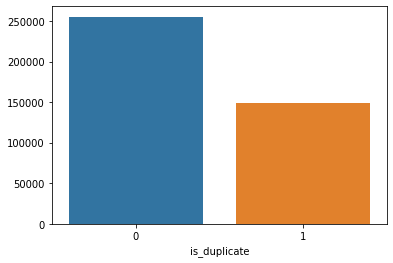

In [ ]:
#Count of duplicates
duplicate_count = df.groupby("is_duplicate")['id'].count()
duplicate_percent = df.groupby("is_duplicate")['id'].count()/df.shape[0]*100
print(duplicate_count, duplicate_percent)

sns.barplot(x = duplicate_count.index,y= duplicate_count.values)


In [17]:
#question 1 and question 2 have null values 
df[df.isnull().any(1)]

,id,qid1,qid2,question1,question2,is_duplicate
105796,105796,209841,209842,How can I develop android app?,NaN,0
201871,201871,398348,398349,How can I create an Android app?,NaN,0
363416,363416,711434,711435,NaN,My Chinese name is Haichao Yu. What English na...,0


In [181]:
#repetition of questions
import numpy as np
questions = list(df['qid1']) + list(df['qid2'])
x = np.array(questions)
unique, counts = np.unique(x, return_counts=True)
x = pd.DataFrame(np.asarray((unique, counts)).T, columns = ['qno', 'freq'])
x = x.sort_values(by = 'freq', ascending = False)
bins = np.array([0,5,10,20,30,40,50,5000])
x["bucket"] = pd.cut(x.freq, bins)

y = x.groupby('bucket')['freq'].sum()
y


bucket
(0, 5]        806031
(5, 10]         1742
(10, 20]         644
(20, 30]         147
(30, 40]           0
(40, 50]         138
(50, 5000]         0
Name: freq, dtype: int64

In [20]:
df_features = pd.merge(X_train, y_train, left_index=True, right_index=True)
X_train.shape, y_train.shape, df_features.shape

((343675, 228), (343675,), (343675, 229))

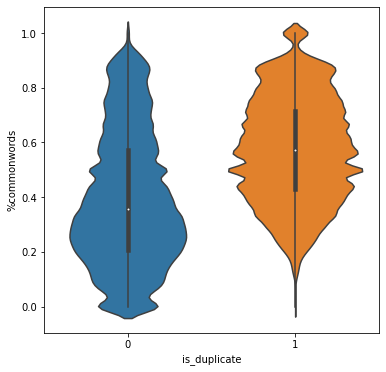

In [48]:
#plot for feature word share
plt.figure(figsize=(6, 6))

sns.violinplot(x = 'is_duplicate', y = '%commonwords', data = df_features)

#Violin plot is thicker for duplicate questions when %common words are more

samequestion         0         1
is_duplicate                    
0             0.538690  0.461310
1             0.362753  0.637247
All           0.473692  0.526308


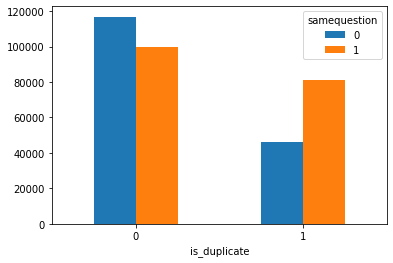

In [122]:
#deep dive on question type - check how many are of same type, and duplication ratio if question is of same type

ct = pd.crosstab(df_features['is_duplicate'],df_features['samequestion'], margins = True, normalize = 'index')

print(ct)

ct = pd.crosstab(df_features['is_duplicate'],df_features['samequestion'])
barplot = ct.plot.bar(rot=0)

#52% of the question pairs are of same type (what, why, where, how, when), 47% are of different type
#Probability of duplicate question increases when question type is same

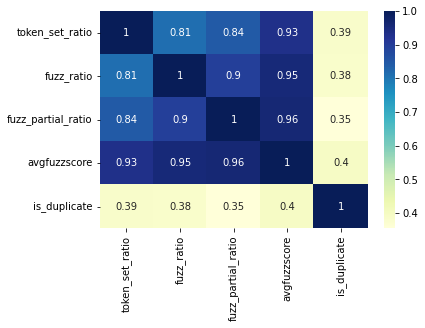

In [129]:
# plotting correlation heatmap for fuzz features

df_fuzz = df_features[['token_set_ratio', 'fuzz_ratio', 'fuzz_partial_ratio','avgfuzzscore','is_duplicate']]
dataplot = sns.heatmap(df_fuzz.corr(), cmap="YlGnBu", annot=True)



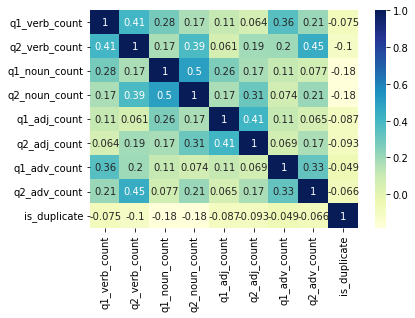

In [130]:

# plotting correlation heatmap for POS counts
df_fuzz = df_features[['q1_verb_count', 'q2_verb_count', 'q1_noun_count', 'q2_noun_count',
       'q1_adj_count', 'q2_adj_count', 'q1_adv_count', 'q2_adv_count','is_duplicate']]
dataplot = sns.heatmap(df_fuzz.corr(), cmap="YlGnBu", annot=True)

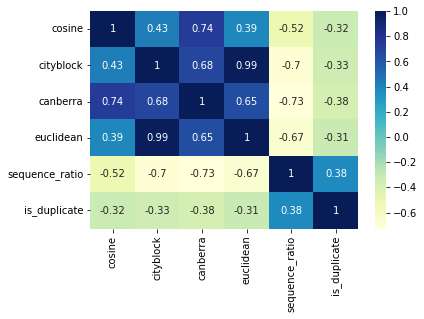

In [131]:
# plotting correlation heatmap for distances
df_fuzz = df_features[['cosine', 'cityblock', 'canberra', 'euclidean', 'sequence_ratio','is_duplicate']]
dataplot = sns.heatmap(df_fuzz.corr(), cmap="YlGnBu", annot=True)

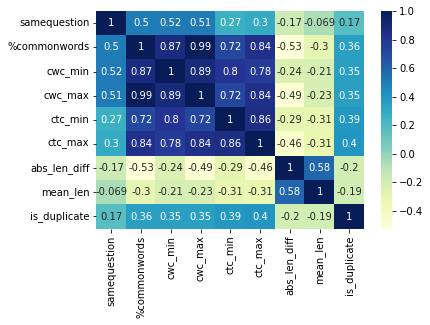

In [132]:
# plotting correlation heatmap for derived features
df_fuzz = df_features[['samequestion', '%commonwords','cwc_min','cwc_max', 
                       'ctc_min', 'ctc_max', 'abs_len_diff', 'mean_len','is_duplicate']]
dataplot = sns.heatmap(df_fuzz.corr(), cmap="YlGnBu", annot=True)

#correlation of 0.35 to 0.4 observed for fuzze features
#Low correlation observed for POS features - with highest correlation for Noun counts
#Sequence ratio, Cityblock and Euclidean distances have higher correlation with duplication of questions
#Amond derived features, stop word ratios (CTC related features) and common word ratios (cwc features) have higher correlations

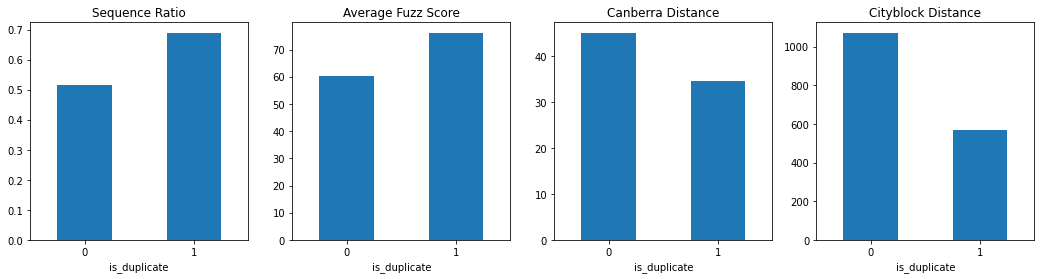

In [79]:
#what is the impact on sequence_ratio, average fuzzscore, and canberra distance

fig, axes = plt.subplots(nrows = 1, ncols = 4, figsize = (18,4))

x = df_features.groupby(['is_duplicate'])['sequence_ratio'].mean()
axes[0].set_title('Sequence Ratio')

ax = x.plot.bar(rot=0, ax = axes[0])

x = df_features.groupby(['is_duplicate'])['avgfuzzscore'].mean()
axes[1].set_title('Average Fuzz Score')

ax = x.plot.bar(rot=0, ax = axes[1])

x = df_features.groupby(['is_duplicate'])['canberra'].mean()
axes[2].set_title('Canberra Distance')

ax = x.plot.bar(rot=0, ax = axes[2])

x = df_features.groupby(['is_duplicate'])['cityblock'].mean()
axes[3].set_title('Cityblock Distance')

ax = x.plot.bar(rot=0, ax = axes[3])

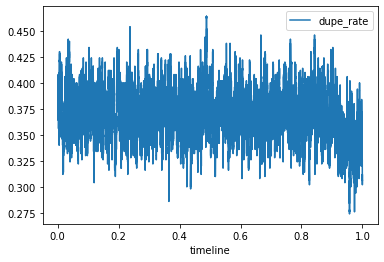

In [106]:
df_temp = df.copy()
df_temp['qmax'] = df_temp.apply(lambda row: max(row['qid1'], row['qid2']), axis = 1)
df_temp = df_temp.sort_values(by = ['qmax'], ascending = True)

df_temp['dupe_rate'] = df_temp.is_duplicate.rolling(window = 500, min_periods = 500).mean()

df_temp['timeline'] = np.arange(df_temp.shape[0])/float(df_temp.shape[0])
df_temp.plot(x = 'timeline', y = 'dupe_rate', kind = 'line')
plt.show()